## Assignment 8: Image Classification Experiments

## Helper and Data Loading Functions

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
from sklearn.metrics import accuracy_score

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training Accuracy', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation Accuracy', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

def load_train_dataset():
    data_path = './tiny-imagenet-200/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

def load_valid_dataset(class_to_idx):
    data_path = './tiny-imagenet-200/val/images'
    label_file = open('./tiny-imagenet-200/val/val_annotations.txt', 'r')
    label_df = pd.read_csv(label_file, sep='\s+', header=None)
    label_df[1] = label_df[1].apply(lambda x : class_to_idx[x])
    valid_data = []
    for row in label_df.iterrows():
        image = Image.open(f'{data_path}/{row[1][0]}')
        image = torchvision.transforms.functional.to_tensor(image)
        label = row[1][1]
        valid_data.append((image, label))
    return valid_data

def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

    valid_data_np = []
    valid_labels = []
    for data, label in valid_dataset:
        if data.shape[0] < 3:
            data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
        valid_data_np.append(data.detach().numpy().flatten())
        valid_labels.append(int(label))
    valid_data_np = np.vstack(valid_data_np)
    valid_labels = np.array(valid_labels)
    return train_data_np, train_labels, valid_data_np, valid_labels

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Boo\AppData\Local\Temp\ipykernel_26256\359687264.py:44: SyntaxWarning: invalid escape sequence '\s'
  label_df = pd.read_csv(label_file, sep='\s+', header=None)


In [2]:
# Load in a training and validation dataset from tiny-imagenet-200
# This file must be in the same folder as the /tiny-imagenet-200 for this to work

train_dataset, class_to_idx = load_train_dataset()
valid_dataset = load_valid_dataset(class_to_idx)

## Convolutional Neural Network in PyTorch

In [9]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [10]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


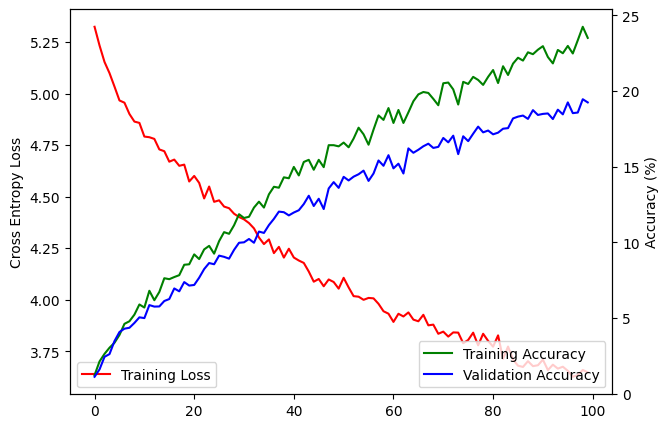

In [ ]:
batch_limit = 100
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        #print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Assignment

Think about a modification to one of the above models you would like to make. You could decide to change the data preparation or splitting, the model architecture, loss function, learning algorithm, or any associated paramter. Implement an experiment that enables you to evaluate the impact of your modification. Make sure that your experiment is only studying the effects of one change. For example, you could compare the learning progress of a neural network model with one hidden layer vs. two hidden layers. In this case, you should make sure to use exactly the same training and validation datasets, the same loss function, and the same learning algorithm.

For each experimental condition, you can use the provided code to generate a learning progress plot, but feel free to explore other tools for evaluation, such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). This would be especially helpful to understand in what way your model is making classification errors.

# Your Response

## What model are you starting with?

I will be evaluating Convolutinal Neural Network

## What modification are you making? Why?

I will be adding more filters in (self.conv) of the original CNN. Orignally, it had up to 32 filters and I will be increasing up to 128 filters. In class, we discussed how these filters in layers allow capturing and learning patterns from the input images. With that idea, I am assuming increased number of fiilter (4 times the original amount) within each layer will allow the model to detect richer context of underlying patterns in each training images. Thus, I am theorising that having more filters will improve the accuracy of the model in predicting testing sets. However, with increase in complexity within the layers, I am also expecting the performance to be slower.

## What data will you use?

For the sake of performance, I will only be using batch size of 100 for both models. I will use all 200 clases for both models. For fair comaprison, the training and testing sets will be same for both model.

## Summary of results and your conclusions

There was visibly definite improvement in both training and validation accuracy with the model with increased number of filters (our experimental model). Training accuracy went up approximately 10% while valdiation accuracy showed marginal increase. However, also as expected, the time performance was a lot slower in the experimental model (8m 36s) compared to our control (4m 9s), doubling the amount of time to iterate 100 times. While this was an expected outcome, I was expecting both training and validation accuracy to show more significant increase then the actual result in our experimental model. Especially looking at how the gradient of increase in accuracy decreases over each iteration, either the detectable patterns are decreasing, or the fiilter has been maximised out of their performances, or there are other limiting factos that needs to be improved/ivestigated. In conclusion, while the modification showed definite improvement, it showed significantly slower performance for the marginal increase in accuracies, suggesting modification of other parameters might be neccesary for improved overall performance of the model.

# Your code below

In [12]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        #increased filter up to 128
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 128 #edited for higher filter value
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

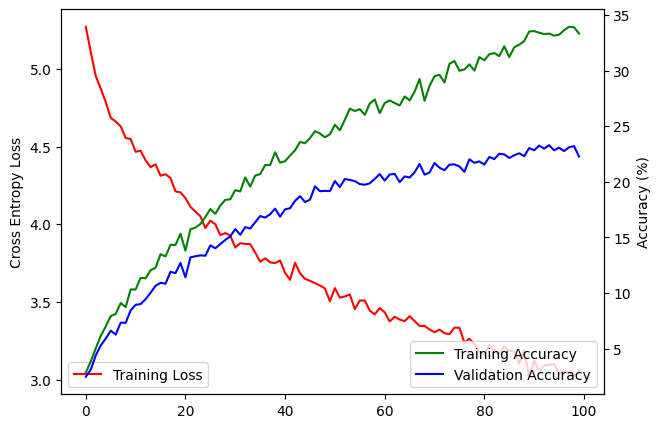

In [13]:
batch_limit = 100
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        #print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 